<a href="https://colab.research.google.com/github/vaibhavsundharam/Super-Sampling/blob/main/Generative_Adversarial_Networks_CelebA_Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will implement super resolution using Generative Adversarial Networks(GAN) from scratch. This work is inspired by the paper "Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network" by Christian Ledig, Lucas Theis, Ferenc Husz´ar, Jose Caballero, Andrew Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan Wang, Wenzhe Shi [[1](https://arxiv.org/abs/1609.04802v5)].

#General Initializations

In [1]:
import torch
import sys
import os
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import PIL
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
import glob
import random
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

Populating the interactive namespace from numpy and matplotlib


In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# modify "customized_path_to_project", path of folder in drive, where you have stored your project
customized_path_to_project = "/content/drive/My Drive/Computer Vision"
sys.path.append(customized_path_to_project)

#Data Preprocessing (data loaders and data augmentation) <br>


CelibA [[2](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)][[3](https://arxiv.org/abs/1411.7766v3)] dataset is a large scale face dataset with more that 200K celebrity face images. In the project we have used a modified subset of the dataset. The images in the modefied dataset have been filtered to obtain only images with clear faces and have been cropped and downsampled to a size of 128x128. The total number of images in this dataset are 126252. 


In [ ]:
#Download CelebA Dataset
!wget https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
!mkdir celeba_data
!unzip q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip -d celeba_data
!rm q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip

In [5]:
import sys
sys.path, dirs, files = next(os.walk("/content/celeba_data/celeba_train_128res"))
file_count = len(files)
print(f"Total number of images: {file_count}")

Total number of images: 126252


###Sample Images form the data set
Following are some of the sample images from the dataset [[2](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)]<br><br>
<img src="https://drive.google.com/uc?export=view&id=1nPBmyAJb5VYBNz1RmLTaB3oS0x5piino" width=800><br>

###Storing image locations in a CSV file for further processing 

In [4]:
import itertools
# Dataset Location
dataset_location = "/content/celeba_data/celeba_train_128res"
csv_file_name = dataset_location.split("/")[-1]+ ".csv"
grabbed = [glob.glob(dataset_location + f) for f in ['/*.jpg', '/*.jpeg', '/*.JPEG', '/*.png', '/*.bmp', '/*.tiff' ]]
merged = list(itertools.chain(*grabbed))
with open(csv_file_name, "w") as out:
    for image_loc in merged:
      out.write(image_loc + "\n")  

#Datasets and Image Augmentations

In [5]:
# custom class to explore dataset
class CelebA_dataset(Dataset):
  def __init__(self, csv_location, HR_shape, scale=4):
    self.hr_height, self.hr_width = HR_shape    
    self.csv = pd.read_csv(csv_location, header=None)
    self.lr_transform = transforms.Compose([
                transforms.Resize((self.hr_height // scale, self.hr_width // scale), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
    self.hr_transform = transforms.Compose([
                transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

  def __len__(self):  # returns the length of the data set
     return len(self.csv)

  def __getitem__(self, idx):  

    images = dict()
    image_location = str(self.csv.iloc[idx, 0])
    image = Image.open(image_location)
    images["HR"] = self.hr_transform(image)
    images["LR"] = self.lr_transform(image)
    return images          

# Data exploration<br>
Here we plot some samples from the training data to visualize it

In [6]:
csvfile_hr = pd.read_csv("/content/celeba_train_128res.csv")
random_samples = random.sample(range(len(csvfile_hr)), k=5) # generating 5 random samples 
images = [csvfile_hr.iloc[i, 0] for i in random_samples]

In [7]:
def plot(images):
  fig, axs = plt.subplots(1, len(images), figsize =(20,20))
  for i in range(len(images)):
    axs[i].imshow(plt.imread(images[i]))
    axs[i].set_title(f"High resolution image {i+1}")     
  plt.show()

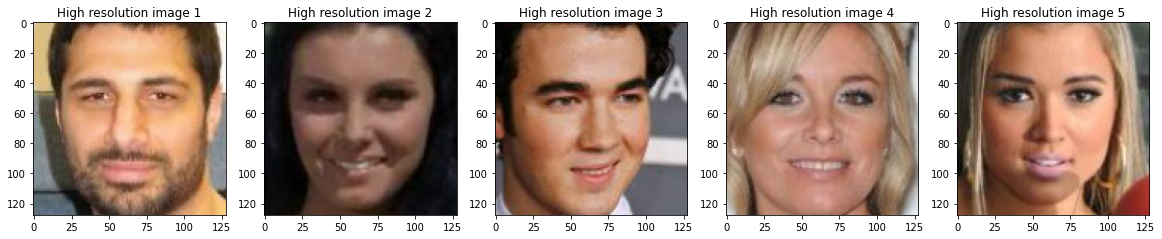

In [8]:
'''plotting 5 random images of our training images'''
plot(images)

# Designing GAN<br>
Following image depicts the architecture of the Generator and Discriminator used in [[1](https://arxiv.org/abs/1609.04802v5)].<br><br>
![picture](https://drive.google.com/uc?export=view&id=1VHFW7OHHplXP-iajx8zvcDP2gpg0JWh3) <br>




Following is a brief description of the SRGAN architecture.

Generator Network


*   A input low-resolution image is fed to the network followed by a convolution block with a kernel size = 9, stride = 1,  number of output channels = 64 and PReLU activation. 
*   Following the previous input block, we have "B" residual blocks. Each of the residual blocks consists of conv-->batch normalization-->PReLU-->conv-->batch normalization followed by an elementwise sum of the input with the output. B such blocks are stacked together. 
*   After the residual blocks we have a convolution layer with a kernel size of 3 and, output dimention of 64 and a stride of 1. 
*   Two more convolution blocks with pixelshuffler and PReLU are used. The last convolution layer with kernel size =9, output dimention = 3 and stride = 1 is used along with Tanh() activation to produce the super-resolution image. 

Discriminator Network


*   A pair of real/actual high-resolution image and the generated super-resolution image is fed to the discriminator one after another to train the discriminator to classify real and fake/generated images. 
*   Instead of using fully connected layers followed by a sigmoid activation, we have used the feature maps directly in an attempt to improve the performance by calculating featurewise loss using MSE loss function.








In [9]:
class TV_Loss(nn.Module): 
  '''Regularization'''
  def __init__(self, tv_loss_weight=1):
    super(TV_Loss, self).__init__()
    self.tv_loss_weight = tv_loss_weight

  def forward(self, sample):
    batch_size = sample.size()[0]
    height = sample.size()[2]
    width = sample.size()[3]
    count_h = self.tensor_size( sample[:, :, 1:, :])
    count_w = self.tensor_size( sample[:, :, :, 1:])
    h_tv = torch.sum(torch.pow(( sample[:, :, 1:, :] -  sample[:, :, :height - 1, :]), 2))
    w_tv = torch.sum(torch.pow(( sample[:, :, :, 1:] -  sample[:, :, :, :width - 1]), 2))
        
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  @staticmethod
  def tensor_size(x):
    return x.size()[1] * x.size()[2] * x.size()[3]

In [10]:
class residual_block(nn.Module):
  '''
  each residual block consists of 2 convolution layers with a kernel size of 3,
  number of channels=64 and a stride of 1
  '''
  def __init__(self, channels, kernel):
    super(residual_block, self).__init__()
    self.convolution_block = nn.Sequential(
                                          nn.Conv2d(channels, channels, kernel, stride=1, padding=1),
                                          nn.BatchNorm2d(channels, 0.8),
                                          nn.PReLU(),
                                          nn.Conv2d(channels, channels, kernel, stride=1, padding=1),
                                          nn.BatchNorm2d(channels, 0.8)
                                          )
  def forward(self, x):
    return x + self.convolution_block(x)

In [11]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=16):
    super(Generator, self).__init__()

    # first convolution block
    self.conv_1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4),
                                    nn.PReLU())
        
    # residual blocks
    residual_blocks = list()
    for _ in range(num_residual_blocks):
      residual_blocks.append(residual_block(channels=64, kernel=3))
    self.residual = nn.Sequential(*residual_blocks)

    # second convolution block after residual blocks
    self.conv_2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
                                nn.BatchNorm2d(64, 0.8))
    
    # upsampling layers
    upsampling_layers = list()
    for _ in range(2):
      upsampling_layers += [nn.Conv2d(64, 256, 3, 1, 1),
                               nn.BatchNorm2d(256),
                               nn.PixelShuffle(upscale_factor=2),
                               nn.PReLU()]
    self.upsampling = nn.Sequential(*upsampling_layers)

    # output layer
    self.conv_3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), 
                                nn.Tanh())

  def forward(self, x):
    out_1 = self.conv_1(x)
    out = self.residual(out_1)
    out_2 = self.conv_2(out)
    out = torch.add(out_1, out_2)
    out = self.upsampling(out)
    out = self.conv_3(out)
    return out

In [12]:
class Discriminator(nn.Module):
  def __init__(self, input_shape, scale=4):
    super(Discriminator, self).__init__()
    self.input_shape = input_shape
    in_channels, in_height, in_width = self.input_shape
    patch_h, patch_w = int(in_height / 2 ** scale), int(in_width / 2 ** scale)
    self.output_shape = (1, patch_h, patch_w)    
    
    in_channels, in_height, in_width = self.input_shape # [-1, 3, patch_size, patch_size]
    
    def d_conv_block(in_channels, out_channels, kernel_size=3, first=False):
      layers = list()
      layers.append(nn.Conv2d(in_filters, out_channels, kernel_size=kernel_size, stride=1, padding=1))
      if not first:
        layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    layers = list()   
    in_filters = in_channels 
    for i, out_filters in enumerate([64, 128, 256, 512]):
      layers.extend(d_conv_block(in_filters, out_filters, first=(i == 0)))
      in_filters = out_filters

    layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
    self.model = nn.Sequential(*layers)
    
  def forward(self, img):
        return self.model(img)

# Model training 

In [13]:
def image_show(lr_images, fake_hr_images, real_hr_images):
  transform = transforms.Compose([transforms.Normalize(mean = [-2.118, -2.036, -1.804], # Equivalent to un-normalizing ImageNet (for correct visualization)
                                                       std = [4.367, 4.464, 4.444]),
                                            transforms.ToPILImage()])
  figure,axs =  plt.subplots(5, 3, figsize =(20,20))
  sample = random.sample(range(0, lr_images.shape[0] -1), 5) # randomly selecting 5 images in the batch    

  for idx, img in enumerate(sample):
    lr_image =transform(lr_images[img])
    fake_hr_image = transform(fake_hr_images[img])
    real_hr_image = transform(real_hr_images[img])
    axs[idx][0].imshow(lr_image)
    axs[idx][0].set_title("Low resolution image")
    axs[idx][1].imshow(fake_hr_image)
    axs[idx][1].set_title("High resolution fake/generated image")
    axs[idx][2].imshow(real_hr_image)
    axs[idx][2].set_title("High resolution real/target image")
  plt.show()

In [14]:
def PSNR(y_real, y_fake):
  assert y_real.shape == y_fake.shape, "Unable to compute PSNR. Input shapes not same." \
                                         " y_true shape = %s, y_pred shape = %s" % (str(y_real.shape),
                                                                                   str(y_fake.shape))  
  mse = torch.mean((y_real - y_fake) ** 2)
  if mse == 0:
      return "Same Image"
  return 10 * torch.log10(1. / mse)   

In [15]:
'''Initializations'''
## Output directory to save weights
output_dir = customized_path_to_project + '/checkpoints/'
os.makedirs(output_dir, exist_ok=True)

# Splittening dataset into training and test set
scale = 4
hr_shape = (224, 224)
dataset =  CelebA_dataset(csv_location="/content/celeba_train_128res.csv", HR_shape=hr_shape, scale=scale)
train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.90),int(len(dataset)*0.10) + 1]) # split 90:10

In [16]:
def train(dataset, SRGAN_train_epoch, channels = 3, hr_shape = (224, 224), batch_size=64, num_workers=8, lr=1e-3, vgg_rescale_coeff=1, adversarial_loss_coeff=1e-3, tv_loss_coeff=1e-3,cont_srgan_training = False):
 
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  writer = SummaryWriter(log_dir=output_dir+"GAN_CelebA_runs")
  
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  print(f"Total number of training example: {len(dataset)}\n")

  ### gererator initialization ###
  generator = Generator(num_residual_blocks=16).to(device)  
  g_optimizer = optim.Adam(generator.parameters(), lr = lr, betas=(0.5, 0.999))
  ############################

  ### discriminator initialization#
  discriminator = Discriminator(input_shape=(3, *hr_shape)).to(device) 
  d_optimizer = optim.Adam(discriminator.parameters(), lr = lr, betas=(0.5, 0.999))     
  #############################

  ### other initializations ###
  total_step = len(loader)
  log_step = 100  
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, mode='max', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)  
  if device == "cuda":
    Tensor =  torch.cuda.FloatTensor
  else:
    Tensor = torch.Tensor
  max_psnr = None
  #############################

  ### initializing VGG model###      
  vgg19 = models.vgg19(pretrained=True)
  modified_vgg19 =  list(vgg19.features.children())[:18]
  vgg19 = nn.Sequential(*modified_vgg19).to(device)
  vgg19.eval()
  #############################
  
  ### initializing lossess ###    
  mse_loss = nn.MSELoss().to(device)  
  tv_loss = TV_Loss().to(device)      
  L1_loss =  nn.L1Loss().to(device)   
  ############################  

  with torch.autograd.set_detect_anomaly(True):     
    if cont_srgan_training == True:
      print("Loading weights")
      generator.load_state_dict(torch.load(os.path.join(output_dir, "weights_GAN_CelebA", "3_best_generator_celebA.pth")))
      discriminator.load_state_dict(torch.load(os.path.join(output_dir, "weights_GAN_CelebA", "3_best_discriminator_celebA.pth")))

    print("------Training SRGAN------")
    for epoch in range(SRGAN_train_epoch):         
      discriminator.train()
      generator.train()          
      mean_generator_perception_loss = 0.0
      mean_generator_adversarial_loss = 0.0
      mean_generator_total_loss = 0.0
      mean_discriminator_loss = 0.0
      mean_generator_tv_loss = 0.0
      mean_psnr = 0.0
      for itr, data in enumerate(loader):   

        # model inputs     
        hr_image = Variable(data["HR"].float().to(device))  # high resolution real
        lr_image = Variable(data["LR"].float().to(device))  # low resolution
        
        # Adversarial ground truths                      
        real = Variable(torch.ones_like(torch.empty(lr_image.size(0), *discriminator.output_shape)),requires_grad=False).to(device)         
        fake = Variable(torch.zeros_like(torch.empty(lr_image.size(0), *discriminator.output_shape)), requires_grad=False).to(device)

        # ------------------
        #  train generator
        # ------------------
        generator.zero_grad()   

        # Generating a high resoution image from low resolution image
        generator_output = generator(lr_image)

        # adversarial loss   = mse(outputs) + mse(image)        
        false_output = discriminator(generator_output)        
        generator_adversarial_loss = adversarial_loss_coeff*mse_loss(false_output, real) + mse_loss(hr_image, generator_output)   


        # perception loss  
        real_vgg_features = vgg19(hr_image)
        fake_vgg_features = vgg19(generator_output)
        generator_perception_loss =  vgg_rescale_coeff*L1_loss(real_vgg_features, fake_vgg_features)         
          
        # tv loss
        total_variance_loss = tv_loss_coeff*tv_loss(generator_output)
        
        # total loss
        generator_total_loss =  generator_perception_loss + generator_adversarial_loss +  total_variance_loss
        
        # storing running values
        mean_generator_perception_loss += generator_perception_loss.item()
        mean_generator_adversarial_loss += generator_adversarial_loss.item()
        mean_generator_tv_loss += total_variance_loss.item()
        mean_generator_total_loss += generator_total_loss.item()
        
        generator_total_loss.backward()
        g_optimizer.step()        
        #---------------------#    

        # ---------------------
        #  train discriminator
        # ---------------------          
        discriminator.zero_grad()

        # loss for real and generated/fake images
        # Generating a high resoution image from low resolution image
        generator_output = generator(lr_image)           
        false_output = discriminator(generator_output)
        real_output = discriminator(hr_image)        
        disc_loss_false = mse_loss(false_output, fake)
        disc_loss_real = mse_loss(real_output, real)

        # total loss
        disc_loss_total = (disc_loss_false + disc_loss_real)/2

        # storing running values
        mean_discriminator_loss += disc_loss_total.item()
        
        disc_loss_total.backward()
        d_optimizer.step()      

        psnr = PSNR(hr_image.cpu().data, generator_output.cpu().data)  
        mean_psnr += psnr
        #---------------------#       
        
        # --------------
        #  Log Progress
        # --------------    
        if itr % log_step == 0:
          sys.stdout.write(f"Printing running logs-Epoch: {epoch+1} Step: {itr}/{total_step}\n")
          # print current loss
          sys.stdout.write(f"Discriminator-> total loss: {disc_loss_total.item()}\n")
          sys.stdout.write(f"Generator-> (perception-loss/adversarial-loss/TV-loss/total-loss): {generator_perception_loss.item()}, {generator_adversarial_loss.item()}, {total_variance_loss.item()}, {generator_total_loss.item()}\n")         
          sys.stdout.write(f"PSNR: {psnr}")
          image_show(lr_image.cpu().data, generator_output.cpu().data, hr_image.cpu().data)
        clear_output(wait=True)
      
      sys.stdout.write(f"Epoch {epoch+1} Lossses\nDiscriminator total-loss: {mean_discriminator_loss/total_step}, Generator (perception-loss/adversarial-loss/TV-loss/total-loss): {mean_generator_perception_loss/total_step}, {mean_generator_adversarial_loss/total_step}, {mean_generator_tv_loss/total_step}, {mean_generator_total_loss/total_step}\n")    
      sys.stdout.write(f"PSNR : {mean_psnr/total_step}")
      
      writer.add_scalar("SRGAN_generator/content_loss", mean_generator_perception_loss/total_step, epoch)
      writer.add_scalar("SRGAN_generator/adversarial_loss", mean_generator_adversarial_loss/total_step, epoch)
      writer.add_scalar("SRGAN_generator/total_loss", mean_generator_total_loss/total_step, epoch)
      writer.add_scalar("SRGAN_discriminator/total_loss", mean_discriminator_loss/total_step, epoch)
      writer.add_scalar("SRGAN PSNR", mean_psnr/total_step, epoch)

      scheduler.step(mean_psnr/total_step)

      if max_psnr == None:
        max_psnr =  mean_psnr/total_step

      if mean_psnr/total_step >= max_psnr:
        sys.stdout.write("\nUpdating best epoch\n")
        max_psnr = mean_psnr/total_step
        # Checkpoint  generator
        torch.save(generator.state_dict(), os.path.join(output_dir, "weights_GAN_CelebA", f"{epoch+1}_best_generator_celebA.pth"))
        # Checkpoint  discriminator
        torch.save(discriminator.state_dict(), os.path.join(output_dir, "weights_GAN_CelebA", f"{epoch+1}_best_discriminator_celebA.pth"))
      clear_output(wait=True)
      if epoch % 5 == 0:
        # Checkpoint  generator
        torch.save(generator.state_dict(), os.path.join(output_dir, "weights_GAN_CelebA", f"{epoch+1}_generator_celebA.pth"))
        # Checkpoint  discriminator
        torch.save(discriminator.state_dict(), os.path.join(output_dir, "weights_GAN_CelebA", f"{epoch+1}_discriminator_celebA.pth"))
      clear_output(wait=True)
    return generator, discriminator  

Printing running logs-Epoch: 7 Step: 900/3551
Discriminator-> total loss: 0.000526613905094564
Generator-> (perception-loss/adversarial-loss/TV-loss/total-loss): 0.006194696761667728, 0.20038388669490814, 5.557119764354468e-10, 0.2065785825252533
PSNR: 7.007058143615723

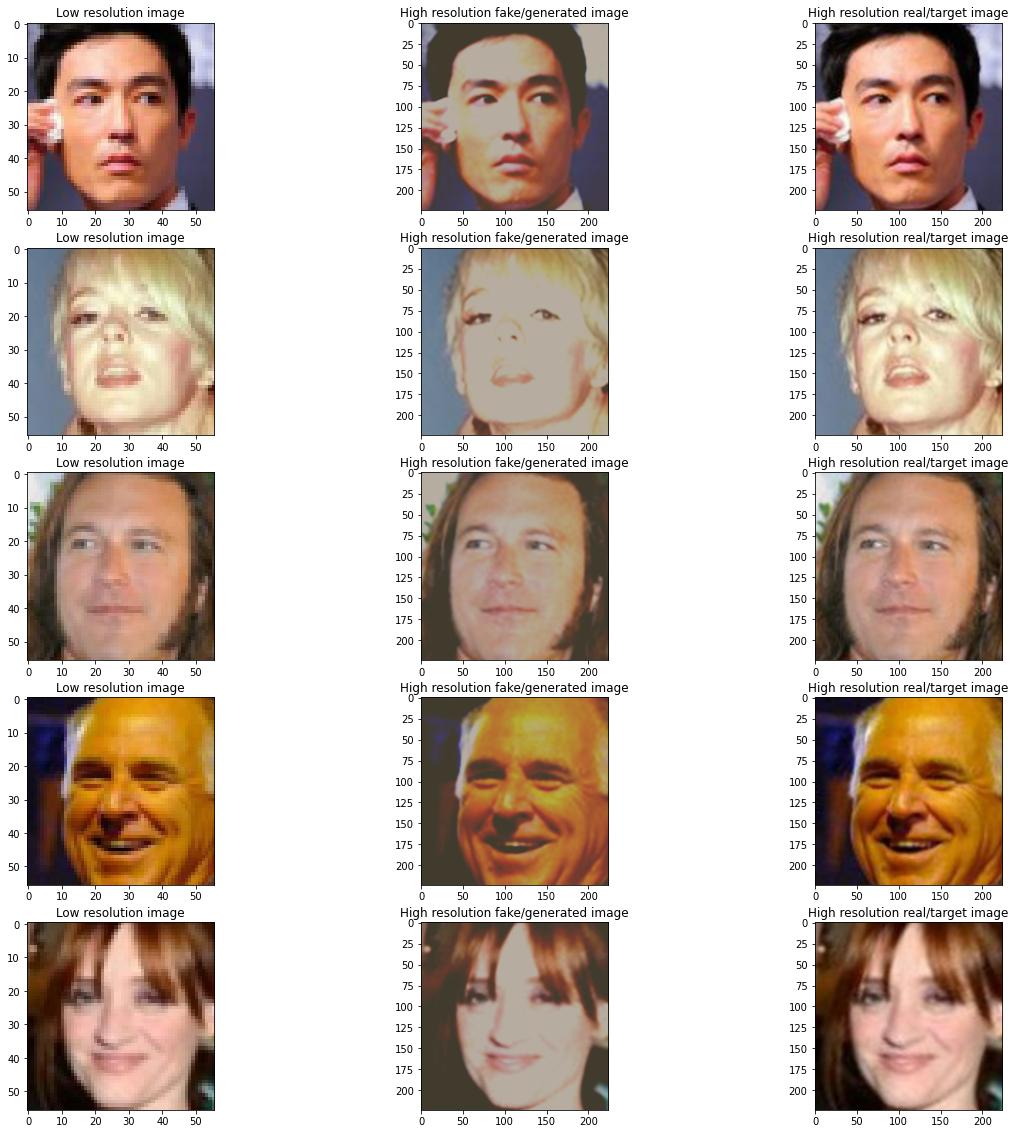

In [ ]:
G, D = train(dataset=train_set,                       
             SRGAN_train_epoch=500, 
             hr_shape = (224, 224),
             lr=1e-3,
             batch_size=32, 
             num_workers=8, 
             vgg_rescale_coeff=0.009,
             adversarial_loss_coeff=1e-3, 
             tv_loss_coeff=2e-8,
             cont_srgan_training = True
             )